In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re

Importando DataFrame de votos por zona no segundo turno de 2018

In [ ]:
df_2018 = pd.read_csv("resultado-zona_presidente_2018.csv")[['sg_uf', 'sg_partido', 'qt_votos_nom_validos']]
df_2018.sg_partido = df_2018.sg_partido.str.replace("PSL", "PL")

# Agrupando por estado e partido 
df_2018 = df_2018.groupby(['sg_uf', 'sg_partido']).sum()

df_2018.columns = ['votos_2018']

df_2018.head()

votos_2018
sg_uf sg_partido            
AC    PL              294899
      PT               86977
AL    PL              610093
      PT              912034
AM    PL              885401

importando o dataframe de dados de votos no primeiro turno de 2022

In [ ]:
df_2022 = pd.read_csv("resultado-zona_presidente_2022.csv")[['sg_uf', 'sg_partido', 'qt_votos_nom_validos']]

df_2022 = df_2022.groupby(['sg_uf', 'sg_partido']).sum()

df_2022.columns = ['votos_2022']

df_2022.head()

votos_2022
sg_uf sg_partido            
AC    DC                  44
      MDB              20122
      NOVO               825
      PCB                144
      PDT              12314

Unindo os dois:

In [ ]:
df = pd.merge(df_2022, df_2018, left_index=True, right_index=True, how='left')
df['delta'] = df['votos_2022'] - df['votos_2018']

df.head()

votos_2022  votos_2018  delta
sg_uf sg_partido                               
AC    DC                  44         NaN    NaN
      MDB              20122         NaN    NaN
      NOVO               825         NaN    NaN
      PCB                144         NaN    NaN
      PDT              12314         NaN    NaN

Baixando os dados de abstenções/nulos/brancos:

In [ ]:
resumo2018 = pd.read_csv("votacao-uf_presidente_2018.csv").set_index('sg_uf').iloc[:, :3]

resumo2018['branco_nulo'] = resumo2018.qt_votos_brancos + resumo2018.qt_votos_nulos
resumo2018 = resumo2018[['qt_votos_nom_validos', 'branco_nulo']]
resumo2018.columns = ['votos', 'bn']

resumo2018.head()

,votos,bn
sg_uf,,
AC,381876,17253
AL,1522127,122332
AM,1761246,148033
AP,368712,26227
BA,7545283,655044


In [ ]:
resumo2022 = pd.read_csv("votacao-uf_presidente_2022.csv").set_index('sg_uf').iloc[:, :3]

resumo2022['branco_nulo'] = resumo2022.qt_votos_brancos + resumo2022.qt_votos_nulos
resumo2022 = resumo2022[['qt_votos_nom_validos', 'branco_nulo']]
resumo2022.columns = ['votos', 'bn']

resumo2022.head()

,votos,bn
sg_uf,,
AC,440917,14986
AL,1724217,81754
AM,2056676,57095
AP,432161,10681
BA,8423008,451833


Pegando a variação:

In [ ]:
df_resumo = resumo2022 - resumo2018

df_resumo.head()

,votos,bn
sg_uf,,
AC,59041,-2267
AL,202090,-40578
AM,295430,-90938
AP,63449,-15546
BA,877725,-203211


Analisando onde Bolsonaro perdeu mais votos:

In [ ]:
df.reset_index(level=0).loc['PL'].sort_values('delta').head(10)

,sg_uf,votos_2022,votos_2018,delta
sg_partido,,,,
PL,SP,12239989,15306023.0,-3066034.0
PL,MG,5239264,6100107.0,-860843.0
PL,RJ,4831246,5669059.0,-837813.0
PL,RS,3245023,3893737.0,-648714.0
PL,PR,3628612,4224416.0,-595804.0
PL,SC,2694406,2966242.0,-271836.0
PL,GO,1920203,2124739.0,-204536.0
PL,DF,910397,1080411.0,-170014.0
PL,ES,1160030,1276611.0,-116581.0


Cores dos partidos a serem plotados:

In [ ]:
colors = {'MDB': '#4169E1', 'PDT': '#F08080', 'PT': '#FF0000', 'NOVO': '#FFA500'}

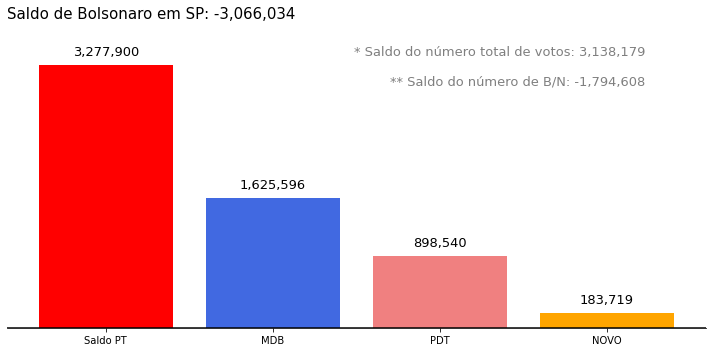

In [ ]:
def plot(df, df_resumo, uf):

  deltaBolsonaro = df.loc[(uf, 'PL'), 'delta']
  df = df.loc[uf].drop('PL') # Exclui o PL

  deltaPT = df.loc['PT', 'delta']
  df = df.loc[colors.keys()].drop('PT').sort_values("votos_2022", ascending=False) # Exclui o PT

  deltabn = df_resumo.loc[uf, 'bn']
  deltaTotal = df_resumo.loc[uf, 'votos']  

  fig, ax = plt.subplots(figsize=(10, 5))

  ax.set_title(f"Saldo de Bolsonaro em {uf}: {'{:,}'.format(int(deltaBolsonaro))}", fontsize=15, loc='left')

  # Remove linhas do grafico
  ax.get_yaxis().set_visible(False)
  ax.spines['right'].set_visible(False)          
  ax.spines['top'].set_visible(False)
  ax.spines['left'].set_visible(False)

# Plota barras
  ax.bar("Saldo PT", deltaPT, color=colors['PT'])
  ax.bar(df.index, df.votos_2022, color=[colors[i] for i in df.index])

# Plota linha em 0
  ax.axhline(y=0, color='k')

# Plota label nas barras
  espaco = .05 * deltaPT
  ax.text(0, deltaPT + espaco, "{:,}".format(int(deltaPT)), ha='center', va='center', fontsize=13)
  for i in range(len(df)):
    value = df.iloc[i, 0]
    ax.text(i + 1, value + espaco, "{:,}".format(int(value)), ha='center', va='center', fontsize=13)
  

# Arruma o limite
  ax.set_ylim(1.1 * ax.get_ylim()[0], 1.1*ax.get_ylim()[1])

# Faz anotações
  ax.text(.9 * ax.get_xlim()[1], .9*ax.get_ylim()[1], f"* Saldo do número total de votos: {'{:,}'.format(int(deltaTotal))}", ha='right', alpha=.5, fontsize=13)
  ax.text(.9 * ax.get_xlim()[1], .8*ax.get_ylim()[1], f"** Saldo do número de B/N: {'{:,}'.format(int(deltabn))}", ha='right', alpha=.5, fontsize=13)  
 
  plt.tight_layout()
  plt.show()

# Mude 'SP' pra qualquer outra sigla
plot(df, df_resumo, 'SP')